In [171]:
import sys
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig
import datetime as dt
import random as rand
import scipy 
from scipy import stats, interp
from IPython import embed
from shutil import copyfile, copy2
from load_intan_rhs_format import read_data

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

In [26]:
def calcmeans(df):
    means = pd.DataFrame()
    for i in range(0,16):
        singlech = df.iloc[:,np.add(i,np.multiply(16,range(0,int(df.shape[1]/16-1))))]
        means = pd.concat([means,np.mean(singlech, axis=1)],axis=1)
    means.columns = range(0,16)
    return means

In [48]:
def detrend(df,base):
    means = calcmeans(base)
    detrended = pd.DataFrame()
    for i in range(0,df.shape[1]):
        if i % 100 == 0:
            print('detrending seg ' + str(i+1) + ' of ' + str(df.shape[1]))
        ch = i % 16
        orig = df.iloc[:,i]
        mean = means[ch]
        new = orig - mean
        detrended = pd.concat([detrended,new],axis=1)
    return detrended

In [172]:
def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = scipy.argmax(f > fmin) - 1
    ind_max = scipy.argmax(f > fmax) - 1
    return scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

In [220]:
def calcfeats(df):
    
    h1 = np.zeros(df.shape[1])
    h4 = np.zeros(df.shape[1])
    h8 = np.zeros(df.shape[1])
    h13 = np.zeros(df.shape[1])
    h25 = np.zeros(df.shape[1])
    h50 = np.zeros(df.shape[1])
    h70 = np.zeros(df.shape[1])
    h130 = np.zeros(df.shape[1])
    for i in range(0,df.shape[1]):
        h1[i] = bandpower(df.iloc[:,i],df.shape[0],1,4)
        h4[i] = bandpower(df.iloc[:,i],df.shape[0],4,8)
        h8[i] = bandpower(df.iloc[:,i],df.shape[0],8,13)
        h13[i] = bandpower(df.iloc[:,i],df.shape[0],13,25)
        h25[i] = bandpower(df.iloc[:,i],df.shape[0],25,50)
        h70[i] = bandpower(df.iloc[:,i],df.shape[0],70,110)
        h130[i] = bandpower(df.iloc[:,i],df.shape[0],130,170)
    
    d = {'max': np.max(df),
         'argmax': df.idxmax(),
         'min': np.min(df),
         'argmin': df.idxmin(),
         '1-4hz': h1,
         '4-8hz': h4,
         '8-13hz': h8,
         '13-25hz': h13,
         '25-50hz': h25,
         '70-110hz': h70,
         '130-170hz': h130
        }
    return pd.DataFrame(d)

In [266]:
def compmat(df1, df2):
    # Welch t-test on every feature for every channel pairwise between df1 and df2
    try:
        df1.shape[1] == df2.shape[1]
    except:
        print(str(df1) + ' and ' + str(df2) + ' do not have the same number of features!')
    comp = pd.DataFrame(1., index=np.arange(16), columns = df1.columns)
    for j in range (0,16):
        for i in df1.columns:
            pval = stats.ttest_ind(df1[i][j],df2[i][j], equal_var=False)[1]
            comp[i][j] = pval
            
    return comp

In [464]:
def reframe(df):
    # Change feature dataframe to be channel
    longp = int(16*df.shape[1])
    shortn = int(df.shape[0]/16)

    newcols = [' ']*longp
 
    for j in range(16):
        for i, col in enumerate(df.columns):
            newcols[df.shape[1]*j + i] = 'ch' + str(j) + ' ' + col
  

    newdf = pd.DataFrame(np.zeros([shortn,longp]), columns = newcols)

    for i, col in enumerate(df.columns):
        
        for j in range (0,16):
            newval = df[col][j]
            newdf.iloc[:,16*i+j] = newval.values
            
            
    return newdf

In [467]:
prefeat = reframe(prefeat03)

interfeat = reframe(interfeat03)
interfeat.head()

,ch0 max,ch0 argmax,ch0 min,ch0 argmin,ch0 1-4hz,ch0 4-8hz,ch0 8-13hz,ch0 13-25hz,ch0 25-50hz,ch0 70-110hz,...,ch15 argmax,ch15 min,ch15 argmin,ch15 1-4hz,ch15 4-8hz,ch15 8-13hz,ch15 13-25hz,ch15 25-50hz,ch15 70-110hz,ch15 130-170hz
0,231.409475,115.792344,234.162486,866.964509,469.676004,135.879358,133.344076,78.285744,180.429533,143.347662,...,39.074429,21.114728,37.593596,29.058965,469.606241,30.755447,59.591366,34.988917,27.762198,69.181239
1,172.896755,97.393232,75.871624,127.776635,916.260424,157.408676,142.488047,89.963472,170.954063,87.408059,...,23.697892,20.114929,30.984089,20.437120,28.971651,21.083967,40.763949,27.642840,21.420276,50.884227
2,238.704625,231.440476,286.758452,846.605447,591.334324,237.187389,220.934356,197.393763,498.498504,165.971179,...,45.561306,30.830213,63.226913,26.178009,1021.789770,22.500740,61.458141,33.247128,31.179430,98.872672
3,178.983994,92.167883,567.009667,419.219352,415.954796,151.981141,180.905096,116.634060,377.457129,109.915343,...,47.534421,29.960824,64.272010,40.255480,171.424129,127.274796,64.213062,42.923574,50.046942,114.921066
4,148.184295,82.187385,69.550484,877.538230,513.601675,115.600866,320.939963,82.954390,436.048612,83.400432,...,16.669587,7.650379,23.641619,12.755459,800.326134,15.406348,27.491987,14.749488,17.685678,110.094760


In [432]:
test = (np.arange(3))
test
int(prefeat03.shape[0]/16)

1055

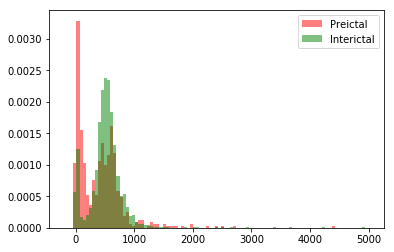

In [225]:
bins = np.linspace(-200, 5000, 100)
plt.hist(prefeat03['1-4hz'][1],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
plt.hist(interfeat03['1-4hz'][1],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
plt.legend(loc = 'upper right')
#plt.xlim(-10000,10000)

In [29]:
# loading in previously computed 1second response traces to each stim for interictal
os.chdir('C:\\Users\\Senan\\SpontStimAnalysis\\Interictal\\RespData')
interictal01 = pd.read_pickle('sKH01interictal1s.pkl')
interictal03 = pd.read_pickle('sKH03interictal1s.pkl')

# loading preictal same
os.chdir('C:\\Users\\Senan\\SpontStimAnalysis\\Preictal\\RespData')
preictal01 = pd.read_pickle('sKH01preictal1s.pkl')
preictal03 = pd.read_pickle('sKH03preictal1s.pkl')

# loading sz times
sztimes01 = pd.read_pickle('sKH01sztimes.pkl')
sztimes03 = pd.read_pickle('sKH03sztimes.pkl')

In [49]:
# detrend compute feats on sKH03 
# using the first 100 interictal responses to detrend all

interdat03 = detrend(interictal03,interictal03.iloc[:,0:1600])

preicdat03 = detrend(preictal03, interictal03.iloc[:,0:1600])


detrending seg 1 of 16880
detrending seg 101 of 16880
detrending seg 201 of 16880
detrending seg 301 of 16880
detrending seg 401 of 16880
detrending seg 501 of 16880
detrending seg 601 of 16880
detrending seg 701 of 16880
detrending seg 801 of 16880
detrending seg 901 of 16880
detrending seg 1001 of 16880
detrending seg 1101 of 16880
detrending seg 1201 of 16880
detrending seg 1301 of 16880
detrending seg 1401 of 16880
detrending seg 1501 of 16880
detrending seg 1601 of 16880
detrending seg 1701 of 16880
detrending seg 1801 of 16880
detrending seg 1901 of 16880
detrending seg 2001 of 16880
detrending seg 2101 of 16880
detrending seg 2201 of 16880
detrending seg 2301 of 16880
detrending seg 2401 of 16880
detrending seg 2501 of 16880
detrending seg 2601 of 16880
detrending seg 2701 of 16880
detrending seg 2801 of 16880
detrending seg 2901 of 16880
detrending seg 3001 of 16880
detrending seg 3101 of 16880
detrending seg 3201 of 16880
detrending seg 3301 of 16880
detrending seg 3401 of 168

In [226]:
# preicdat03.head()

prefeat03 = calcfeats(preicdat03)

print('next')

interfeat03 = calcfeats(interdat03)

print('done')


# interfeat03.head()

next
done


In [227]:
interfeat03.head()

,max,argmax,min,argmin,1-4hz,4-8hz,8-13hz,13-25hz,25-50hz,70-110hz,130-170hz
0,231.409475,156,-495.858702,1,1009.478001,167.578523,287.921505,247.738156,278.332396,114.804339,66.472039
1,115.792344,1881,-141.538087,1021,11.546824,10.982297,28.161660,53.294675,119.861850,61.843326,27.275763
2,234.162486,1881,-493.549960,3,9868.753818,2031.086439,658.663863,600.351954,414.654181,131.499244,60.218255
3,866.964509,1,-169.532957,1021,405.493572,399.896292,349.788650,685.617655,704.437522,260.685780,103.591172
4,469.676004,158,-1601.562295,0,8080.747095,1131.079329,686.871791,770.420201,756.082305,469.558128,317.993327


In [228]:
prefeat03.head()

,max,argmax,min,argmin,1-4hz,4-8hz,8-13hz,13-25hz,25-50hz,70-110hz,130-170hz
0,197.457165,70,-522.319888,0,1019.884156,247.081084,272.612903,290.785243,239.317485,167.413387,62.808930
1,171.910773,0,-99.280150,612,298.680438,58.704380,31.216621,51.381048,117.951427,106.877740,28.757043
2,361.273770,1539,-1259.159260,3,82625.164637,12475.790976,4587.875384,4193.011094,2197.083425,629.272907,233.540949
3,722.946491,70,-2007.527260,0,23988.095946,4019.282922,2450.541128,2806.410362,2302.961842,924.614178,402.444193
4,504.794021,149,-1235.123478,0,8639.566061,1020.091875,650.944802,528.976662,533.931952,598.872084,413.480872


In [38]:
preicdat03.head()

,0,1,2,3,4,5,6,7,8,9,...,6,7,8,9,10,11,12,13,14,15
0,-1643.398301,-16.575546,1308.425064,1812.858175,-3568.588953,69.447808,-4541.488582,52.518931,-89.944118,-545.725727,...,4182.521509,98.212773,4930.754903,144.927110,4756.466494,-31.986172,-161.762296,-165.556150,-1539.882160,5661.377133
1,-1468.719347,61.403868,1396.674486,1825.386424,-2967.618806,76.865719,-4214.864706,54.375842,76.536539,-432.018099,...,3937.622633,64.094993,4711.407375,127.186664,4546.590867,-58.588637,-191.587859,-78.625545,-1368.707615,5422.868413
2,-1030.017614,112.422310,1367.493737,1615.549653,-2233.391422,90.325600,-3528.300886,80.774413,30.842877,-305.963019,...,3700.276560,76.709021,4673.880782,57.533561,4331.605826,-38.649800,-139.536184,-111.834666,-1336.782346,5232.464268
3,-873.584548,117.953181,1332.623153,1590.366700,-1905.425673,83.537480,-3095.135633,78.912874,73.127253,-262.774226,...,3609.806113,72.153009,4612.091953,128.239260,4285.470192,-51.992324,-206.902621,-149.746578,-1259.267087,5127.745862
4,-739.055003,139.326738,1357.967782,1423.064531,-1626.478908,48.878602,-2777.277891,45.236889,54.928362,-171.684560,...,3307.552066,58.649734,4505.850723,51.026751,4032.259843,-49.381990,-149.449217,-98.587419,-1194.055052,4914.462200


In [58]:
os.chdir('C:\\Users\\Senan\\SpontStimAnalysis\\Interictal\\RespData')
interdat03.to_pickle('interictal03_detrended.pkl')
interfeat03.to_pickle('interfeat03.pkl')

preicdat03.to_pickle('preictal03_detrended.pkl')
prefeat03.to_pickle('prefeat03.pkl')

In [59]:
test = pd.read_pickle('interfeat03.pkl')

In [60]:
test.head()

,max,argmax,min,argmin
0,231.409475,156,-495.858702,1
1,115.792344,1881,-141.538087,1021
2,234.162486,1881,-493.549960,3
3,866.964509,1,-169.532957,1021
4,469.676004,158,-1601.562295,0


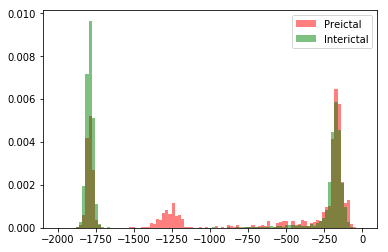

In [133]:

bins = np.linspace(-2000, 0, 100)
plt.hist(prefeat03['min'][2],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
plt.hist(interfeat03['min'][2],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
plt.legend(loc = 'upper right')
#plt.xlim(-10000,10000)


(-2000, 0)

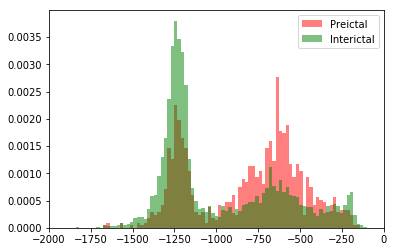

In [118]:

bins = np.linspace(-2000, 0, 100)
plt.hist(prefeat03['min'][15],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
plt.hist(interfeat03['min'][15],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
plt.legend(loc = 'upper right')
plt.xlim(-2000,0)

In [169]:
prefeatcut = prefeat03.iloc[16*0:16*800]

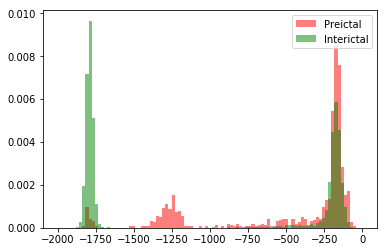

In [170]:
bins = np.linspace(-2000, 0, 100)
plt.hist(prefeatcut['min'][2],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
plt.hist(interfeat03['min'][2],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
plt.legend(loc = 'upper right')
#plt.xlim(-10000,10000)

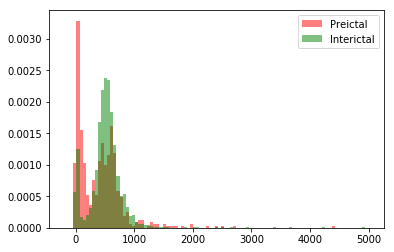

In [229]:
bins = np.linspace(-200, 5000, 100)
plt.hist(prefeat03['1-4hz'][1],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
plt.hist(interfeat03['1-4hz'][1],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
plt.legend(loc = 'upper right')

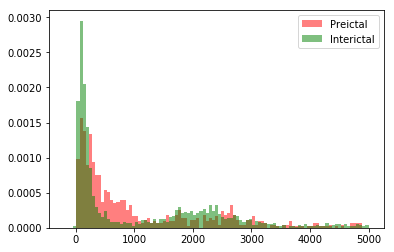

In [231]:
bins = np.linspace(-200, 5000, 100)
ch = 0
plt.hist(prefeat03['4-8hz'][ch],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
plt.hist(interfeat03['4-8hz'][ch],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
plt.legend(loc = 'upper right')

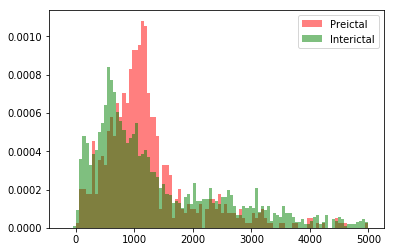

In [235]:
bins = np.linspace(-200, 5000, 100)
ch = 4
feat = '4-8hz'
plt.hist(prefeat03['4-8hz'][ch],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
plt.hist(interfeat03['4-8hz'][ch],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
plt.legend(loc = 'upper right')
plt.title()

Text(0, 0.5, 'PDF')

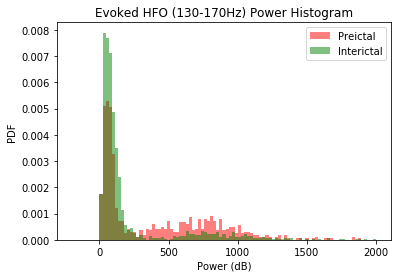

In [265]:
bins = np.linspace(-200, 2000, 100)
ch = 15
feat = '130-170hz'
plt.hist(prefeat03[feat][ch],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
plt.hist(interfeat03[feat][ch],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
plt.legend(loc = 'upper right')
plt.title('Evoked HFO (130-170Hz) Power Histogram')
plt.xlabel('Power (dB)')
plt.ylabel('PDF')

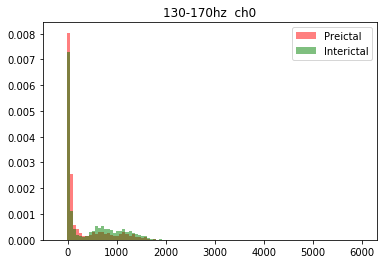

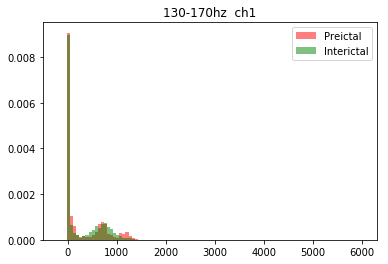

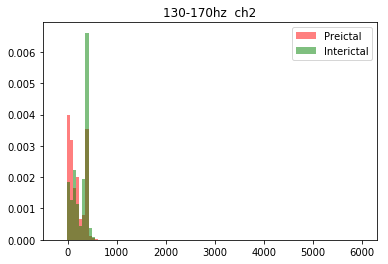

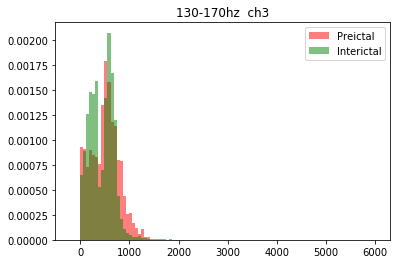

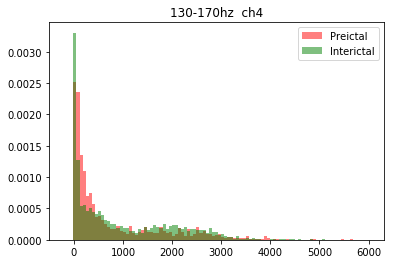

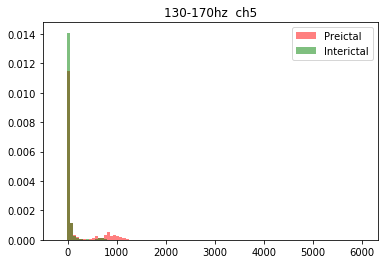

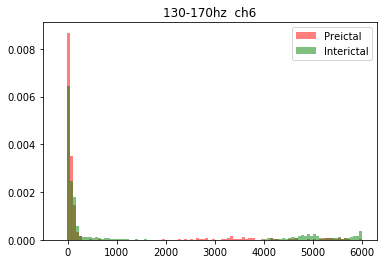

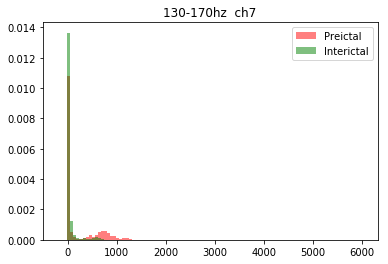

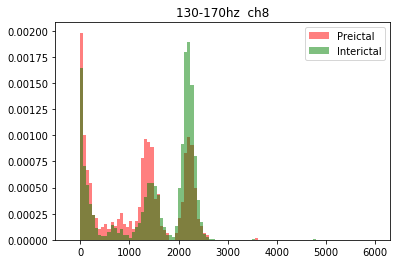

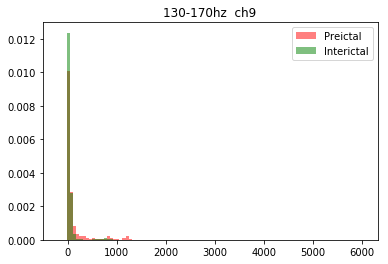

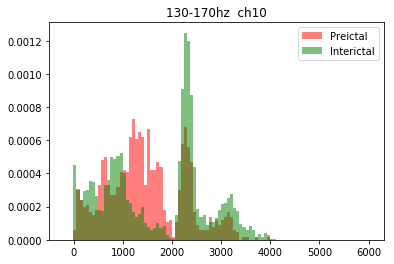

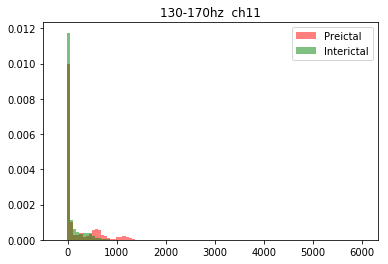

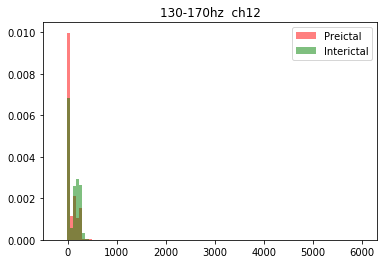

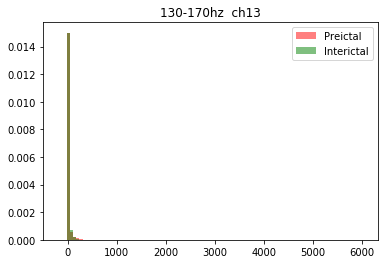

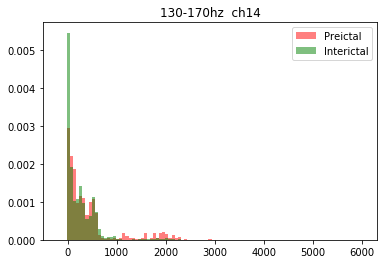

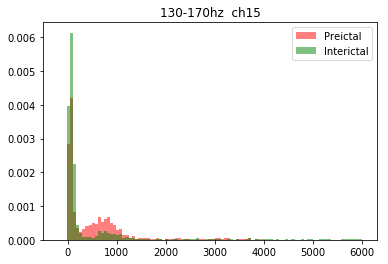

In [260]:
for ch in range(0,16):
    bins = np.linspace(-200, 6000, 100)
    feat = '130-170hz'
    plt.figure()
    plt.hist(prefeat03[feat][ch],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
    plt.hist(interfeat03[feat][ch],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
    plt.legend(loc = 'upper right')
    plt.title(feat + '  ch' + str(ch))

Text(0.5, 1.0, 'Baseline-preictal feature changes by Welch T-test (Subject 1)')

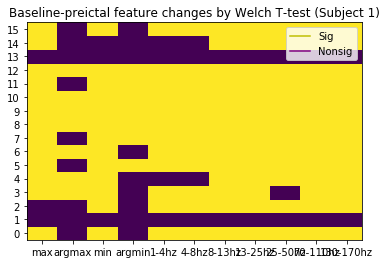

In [284]:
tf01 = compmat(interfeat03,prefeat03) < 0.01/(16*11)
plt.pcolor(tf01)
plt.yticks(np.arange(0.5, len(tf01.index), 1), tf01.index)
plt.xticks(np.arange(0.5, len(tf01.columns), 1), tf01.columns)

plt.plot(0,0,'y')
plt.plot(0,0,'purple')
plt.legend(('Sig','Nonsig'))
plt.title('Baseline-preictal feature changes by Welch T-test (Subject 1)')

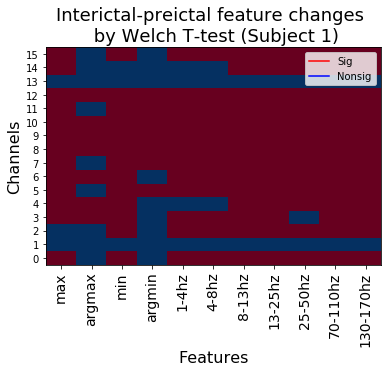

<Figure size 11520x11520 with 0 Axes>

In [327]:
tf02 = ~(compmat(interfeat03,prefeat03) < 0.01/(16*11))
fig = plt.pcolor(tf02)
plt.set_cmap('RdBu')
plt.yticks(np.arange(0.5, len(tf01.index), 1), tf01.index)
plt.xticks(np.arange(0.5, len(tf01.columns), 1), tf01.columns)

plt.plot(0,0,'r')
plt.plot(0,0,'b')
plt.legend(('Sig','Nonsig'))
plt.ylabel('Channels', fontsize = 16)
plt.xlabel('Features', fontsize = 16)
plt.title('Interictal-preictal feature changes \n by Welch T-test (Subject 1)', fontsize = 18)
plt.figure(figsize=(160,160))

axe = fig.axes
ax = axe
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation('vertical')


In [287]:
prefeat03.shape[0]/16

1055.0

In [288]:
interfeat03.shape[0]/16

3362.0

In [359]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [498]:
# Code below from Emma
n_splits_o = 5
n_splits_i = 4
animal_ID = 1
factor_red = 1

# To reduce the computational expense and the number of features to try in PCA during Hyperparameter optimization
nb_feats_min = 60
nb_feats_max = 100

animal_ID = animal_ID
animal_names = {1: "1", 2: "2"}

In [499]:
# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# Load in dataset.
# data = spio.loadmat("features_10s_2019-01-30.mat");

featuresp = prefeat
labelsp = np.ones(prefeat.shape[0])

features = featuresp.append(interfeat)
labels = np.append(labelsp, np.zeros(interfeat.shape[0]))

# animal_id_features = data['animal_id_features'];

# Flatten animal IDs so we can slice by animal.
# id_features = np.ravel(animal_id_features);

# Indexes animal of interest.
# indexes = np.where(id_features == animal_ID)
# indexes = np.ravel(indexes)

# Get only features corresponding to animal selected.
# animal_features = np.array([features[index, :] for index in indexes])
# labels = labels.transpose()
# animal_labels = np.array([labels[index] for index in indexes]);

In [500]:
print(features.shape)
print(labels.shape)

(4417, 176)
(4417,)


In [501]:
"""Reducing the size of the vectors for easier computation"""
# factor = factor_red
factor = 1
animal_features = features.values
animal_labels = labels
"""Shuffling the data to train/test on smaller subsets"""
shuffled_animal_features = np.empty(animal_features.shape, dtype=animal_features.dtype)
shuffled_animal_labels = np.empty(animal_labels.shape, dtype=animal_labels.dtype)
permutation = np.random.permutation(len(animal_labels))
for old_index, new_index in enumerate(permutation):
        shuffled_animal_features [new_index] = animal_features[old_index]
        shuffled_animal_labels[new_index] = animal_labels[old_index]
animal_features = shuffled_animal_features
animal_labels = shuffled_animal_labels

animal_features = animal_features[0:int(len(animal_features)/factor),:]
animal_labels = animal_labels[0:np.int(len(animal_labels)/factor)]

In [502]:
print(animal_labels.shape)
print(animal_features.shape)

(4417,)
(4417, 176)


Process ended, outer fold  0 , inner fold  0
Process ended, outer fold  0 , inner fold  1
Process ended, outer fold  0 , inner fold  2
Process ended, outer fold  0 , inner fold  3
Process ended, outer fold  0
Process ended, outer fold  1 , inner fold  0
Process ended, outer fold  1 , inner fold  1
Process ended, outer fold  1 , inner fold  2
Process ended, outer fold  1 , inner fold  3
Process ended, outer fold  1
Process ended, outer fold  2 , inner fold  0
Process ended, outer fold  2 , inner fold  1
Process ended, outer fold  2 , inner fold  2
Process ended, outer fold  2 , inner fold  3
Process ended, outer fold  2
Process ended, outer fold  3 , inner fold  0
Process ended, outer fold  3 , inner fold  1
Process ended, outer fold  3 , inner fold  2
Process ended, outer fold  3 , inner fold  3
Process ended, outer fold  3
Process ended, outer fold  4 , inner fold  0
Process ended, outer fold  4 , inner fold  1
Process ended, outer fold  4 , inner fold  2
Process ended, outer fold  4 

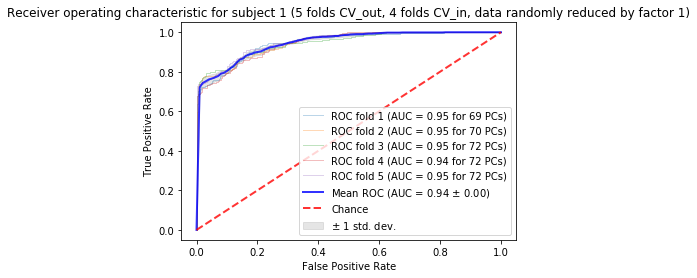

In [503]:
"""Split data into training and testing sets"""

# parameters:
n_splits_o = n_splits_o
n_splits_i = n_splits_i
nb_features_tot = animal_features.shape[1]

cv_o = StratifiedKFold(n_splits=n_splits_o)
cv_i = StratifiedKFold(n_splits=n_splits_i)


AUC_i = np.zeros((n_splits_o, n_splits_i, nb_features_tot))
AUC_means = np.zeros((n_splits_o, nb_features_tot))
# Acc_train_i = np.zeros((n_splits_o, n_splits_i))
# Acc_val_i = np.zeros((n_splits_o, n_splits_i))
Best_features = np.zeros(n_splits_o)
Best_features_valAUC = np.zeros(n_splits_o)
AUC_o = np.zeros(n_splits_o)

tprs = []
mean_fpr = np.linspace(0, 1, 100)


"""Outer loop"""
k_out = 0
for train_o, test in cv_o.split(animal_features, animal_labels):
    data_train_o = animal_features[train_o]
    data_test = animal_features[test]
    labels_train_o = animal_labels[train_o]
    labels_test = animal_labels[test]
    
    """Inner Loop"""
    k_in = 0
    for train_i, val in cv_i.split(data_train_o, labels_train_o):

        data_train_i = animal_features[train_i]
        data_val = animal_features[val]
        labels_train_i = animal_labels[train_i]
        labels_val = animal_labels[val]

        """Hyperparameter evaluation: Number of features to keep after PCA"""
        for k_feat in range(nb_feats_min, nb_feats_max):
            features_kept = k_feat + 1 

            clf = make_pipeline(StandardScaler(), PCA(n_components=features_kept), svm.SVC(kernel='rbf', gamma='scale', probability=True))
            y_score = clf.fit(data_train_i, labels_train_i)

            y_predict = clf.predict_proba(data_val)
            y_predict_train = clf.predict(data_train_i)

#             Acc_val_i[k_out, k_in] = metrics.accuracy_score(labels_val, y_predict)
#             Acc_train_i[k_out, k_in] = metrics.accuracy_score(labels_train_i, y_predict_train)
            fpr, tpr, thresholds = roc_curve(labels_val, y_predict[:, 1])
            AUC_i[k_out, k_in, k_feat] = auc(fpr, tpr)
        
        print('Process ended, outer fold ', k_out, ', inner fold ', k_in)
        k_in += 1
        
    AUC_means = np.mean(AUC_i, axis=1)
    
    """Choice of the best performing Hyperparameters:"""
    Best_features[k_out] = int(np.argmax(AUC_means[k_out,:]) + 1)
    Best_features_valAUC[k_out] = np.max(AUC_means[k_out,:])
    
    """Performance on the test set"""
    clf = make_pipeline(StandardScaler(), PCA(n_components=int(Best_features[k_out])), svm.SVC(kernel='rbf', gamma='scale', probability=True))
    y_score = clf.fit(data_train_o, labels_train_o)
    
    y_predict = clf.predict_proba(data_test)
    y_predict_train = clf.predict(data_train_o)
    
    """ROC curve"""
    fpr, tpr, thresholds = roc_curve(labels_test, y_predict[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    AUC_o[k_out] = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f for %d PCs)' % (k_out+1, AUC_o[k_out], int(Best_features[k_out])))  
    
    print('Process ended, outer fold ', k_out)
    k_out += 1

"""mean ROC curve"""             
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(AUC_o)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')       
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for subject %s (%d folds CV_out, %d folds CV_in, data randomly reduced by factor %d)' % (animal_names[animal_ID], n_splits_o, n_splits_i, factor_red))
plt.legend(loc="lower right")
plt.savefig('ROC_' + animal_names[animal_ID] + '.png')  
plt.show()

In [506]:
interdat01 = detrend(interictal01,interictal01.iloc[:,0:1600])

preicdat01 = detrend(preictal01, interictal01.iloc[:,0:1600])



detrending seg 1 of 53792
detrending seg 101 of 53792
detrending seg 201 of 53792
detrending seg 301 of 53792
detrending seg 401 of 53792
detrending seg 501 of 53792
detrending seg 601 of 53792
detrending seg 701 of 53792
detrending seg 801 of 53792
detrending seg 901 of 53792
detrending seg 1001 of 53792
detrending seg 1101 of 53792
detrending seg 1201 of 53792
detrending seg 1301 of 53792
detrending seg 1401 of 53792
detrending seg 1501 of 53792
detrending seg 1601 of 53792
detrending seg 1701 of 53792
detrending seg 1801 of 53792
detrending seg 1901 of 53792
detrending seg 2001 of 53792
detrending seg 2101 of 53792
detrending seg 2201 of 53792
detrending seg 2301 of 53792
detrending seg 2401 of 53792
detrending seg 2501 of 53792
detrending seg 2601 of 53792
detrending seg 2701 of 53792
detrending seg 2801 of 53792
detrending seg 2901 of 53792
detrending seg 3001 of 53792
detrending seg 3101 of 53792
detrending seg 3201 of 53792
detrending seg 3301 of 53792
detrending seg 3401 of 537

In [507]:
prefeat1 = calcfeats(preicdat01)

print('next')

interfeat1 = calcfeats(interdat01)

print('done')

next
done


In [508]:
prefeat = reframe(prefeat1)

interfeat = reframe(interfeat1)

In [509]:
# Code below from Emma
n_splits_o = 5
n_splits_i = 4
animal_ID = 2
factor_red = 1

# To reduce the computational expense and the number of features to try in PCA during Hyperparameter optimization
nb_feats_min = 60
nb_feats_max = 100

animal_ID = animal_ID
animal_names = {1: "1", 2: "2"}

In [510]:
# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# Load in dataset.
# data = spio.loadmat("features_10s_2019-01-30.mat");

featuresp = prefeat
labelsp = np.ones(prefeat.shape[0])

features = featuresp.append(interfeat)
labels = np.append(labelsp, np.zeros(interfeat.shape[0]))

# animal_id_features = data['animal_id_features'];

# Flatten animal IDs so we can slice by animal.
# id_features = np.ravel(animal_id_features);

# Indexes animal of interest.
# indexes = np.where(id_features == animal_ID)
# indexes = np.ravel(indexes)

# Get only features corresponding to animal selected.
# animal_features = np.array([features[index, :] for index in indexes])
# labels = labels.transpose()
# animal_labels = np.array([labels[index] for index in indexes]);

In [529]:
print(features.shape)
print(labels.shape)

(3622, 176)
(3622,)


In [531]:
"""Reducing the size of the vectors for easier computation"""
# factor = factor_red
factor = 1
animal_features = features.values
animal_labels = labels
"""Shuffling the data to train/test on smaller subsets"""
shuffled_animal_features = np.empty(animal_features.shape, dtype=animal_features.dtype)
shuffled_animal_labels = np.empty(animal_labels.shape, dtype=animal_labels.dtype)
permutation = np.random.permutation(len(animal_labels))
for old_index, new_index in enumerate(permutation):
        shuffled_animal_features [new_index] = animal_features[old_index]
        shuffled_animal_labels[new_index] = animal_labels[old_index]
animal_features = shuffled_animal_features
animal_labels = shuffled_animal_labels

animal_features = animal_features[0:int(len(animal_features)/factor),:]
animal_labels = animal_labels[0:np.int(len(animal_labels)/factor)]

In [532]:
print(animal_labels.shape)
print(animal_features.shape)

(3622,)
(3622, 176)


Process ended, outer fold  0 , inner fold  0
Process ended, outer fold  0 , inner fold  1
Process ended, outer fold  0 , inner fold  2
Process ended, outer fold  0 , inner fold  3
Process ended, outer fold  0
Process ended, outer fold  1 , inner fold  0
Process ended, outer fold  1 , inner fold  1
Process ended, outer fold  1 , inner fold  2
Process ended, outer fold  1 , inner fold  3
Process ended, outer fold  1
Process ended, outer fold  2 , inner fold  0
Process ended, outer fold  2 , inner fold  1
Process ended, outer fold  2 , inner fold  2
Process ended, outer fold  2 , inner fold  3
Process ended, outer fold  2
Process ended, outer fold  3 , inner fold  0
Process ended, outer fold  3 , inner fold  1
Process ended, outer fold  3 , inner fold  2
Process ended, outer fold  3 , inner fold  3
Process ended, outer fold  3
Process ended, outer fold  4 , inner fold  0
Process ended, outer fold  4 , inner fold  1
Process ended, outer fold  4 , inner fold  2
Process ended, outer fold  4 

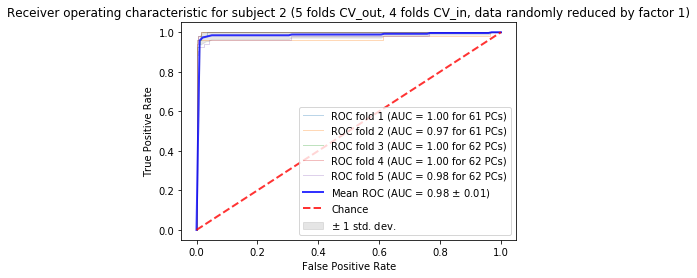

In [514]:
"""Split data into training and testing sets"""

# parameters:
n_splits_o = n_splits_o
n_splits_i = n_splits_i
nb_features_tot = animal_features.shape[1]

cv_o = StratifiedKFold(n_splits=n_splits_o)
cv_i = StratifiedKFold(n_splits=n_splits_i)


AUC_i = np.zeros((n_splits_o, n_splits_i, nb_features_tot))
AUC_means = np.zeros((n_splits_o, nb_features_tot))
# Acc_train_i = np.zeros((n_splits_o, n_splits_i))
# Acc_val_i = np.zeros((n_splits_o, n_splits_i))
Best_features = np.zeros(n_splits_o)
Best_features_valAUC = np.zeros(n_splits_o)
AUC_o = np.zeros(n_splits_o)

tprs = []
mean_fpr = np.linspace(0, 1, 100)


"""Outer loop"""
k_out = 0
for train_o, test in cv_o.split(animal_features, animal_labels):
    data_train_o = animal_features[train_o]
    data_test = animal_features[test]
    labels_train_o = animal_labels[train_o]
    labels_test = animal_labels[test]
    
    """Inner Loop"""
    k_in = 0
    for train_i, val in cv_i.split(data_train_o, labels_train_o):

        data_train_i = animal_features[train_i]
        data_val = animal_features[val]
        labels_train_i = animal_labels[train_i]
        labels_val = animal_labels[val]

        """Hyperparameter evaluation: Number of features to keep after PCA"""
        for k_feat in range(nb_feats_min, nb_feats_max):
            features_kept = k_feat + 1 

            clf = make_pipeline(StandardScaler(), PCA(n_components=features_kept), svm.SVC(kernel='rbf', gamma='scale', probability=True))
            y_score = clf.fit(data_train_i, labels_train_i)

            y_predict = clf.predict_proba(data_val)
            y_predict_train = clf.predict(data_train_i)

#             Acc_val_i[k_out, k_in] = metrics.accuracy_score(labels_val, y_predict)
#             Acc_train_i[k_out, k_in] = metrics.accuracy_score(labels_train_i, y_predict_train)
            fpr, tpr, thresholds = roc_curve(labels_val, y_predict[:, 1])
            AUC_i[k_out, k_in, k_feat] = auc(fpr, tpr)
        
        print('Process ended, outer fold ', k_out, ', inner fold ', k_in)
        k_in += 1
        
    AUC_means = np.mean(AUC_i, axis=1)
    
    """Choice of the best performing Hyperparameters:"""
    Best_features[k_out] = int(np.argmax(AUC_means[k_out,:]) + 1)
    Best_features_valAUC[k_out] = np.max(AUC_means[k_out,:])
    
    """Performance on the test set"""
    clf = make_pipeline(StandardScaler(), PCA(n_components=int(Best_features[k_out])), svm.SVC(kernel='rbf', gamma='scale', probability=True))
    y_score = clf.fit(data_train_o, labels_train_o)
    
    y_predict = clf.predict_proba(data_test)
    y_predict_train = clf.predict(data_train_o)
    
    """ROC curve"""
    fpr, tpr, thresholds = roc_curve(labels_test, y_predict[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    AUC_o[k_out] = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f for %d PCs)' % (k_out+1, AUC_o[k_out], int(Best_features[k_out])))  
    
    print('Process ended, outer fold ', k_out)
    k_out += 1

"""mean ROC curve"""             
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(AUC_o)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')       
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for subject %s (%d folds CV_out, %d folds CV_in, data randomly reduced by factor %d)' % (animal_names[animal_ID], n_splits_o, n_splits_i, factor_red))
plt.legend(loc="lower right")
plt.savefig('ROC_' + animal_names[animal_ID] + '.png')  
plt.show()

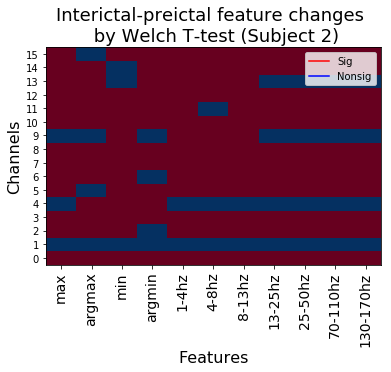

<Figure size 11520x11520 with 0 Axes>

In [526]:
tf03 = ~(compmat(interfeat1,prefeat1) < 0.01/(16*11))
fig = plt.pcolor(tf03)
plt.set_cmap('RdBu')
plt.yticks(np.arange(0.5, len(tf03.index), 1), tf03.index)
plt.xticks(np.arange(0.5, len(tf03.columns), 1), tf03.columns)

plt.plot(0,0,'r')
plt.plot(0,0,'b')
plt.legend(('Sig','Nonsig'))
plt.ylabel('Channels', fontsize = 16)
plt.xlabel('Features', fontsize = 16)
plt.title('Interictal-preictal feature changes \n by Welch T-test (Subject 2)', fontsize = 18)
plt.figure(figsize=(160,160))

axe = fig.axes
ax = axe
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation('vertical')

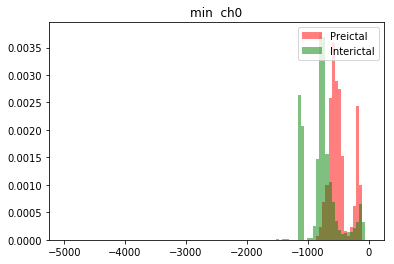

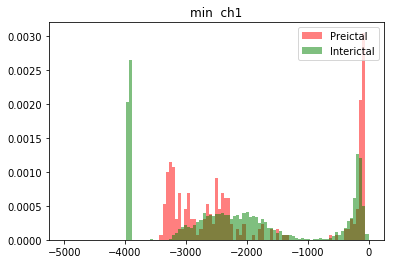

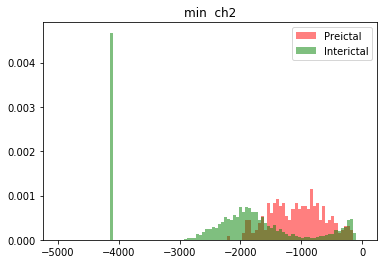

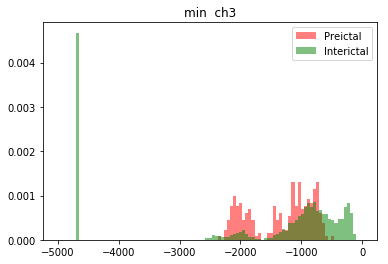

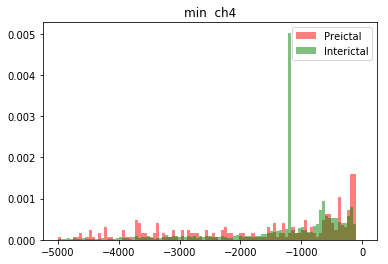

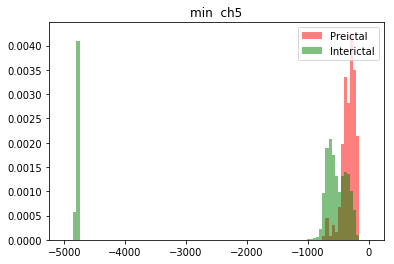

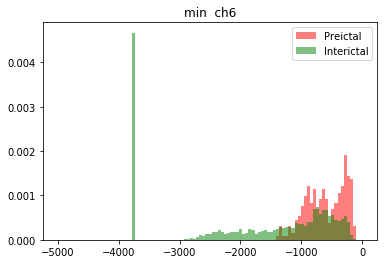

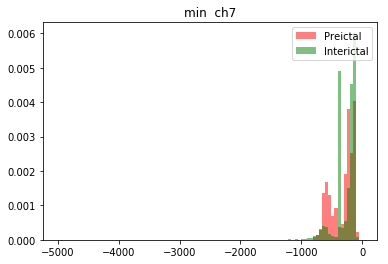

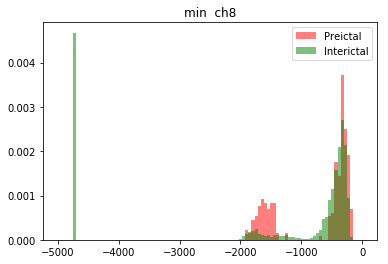

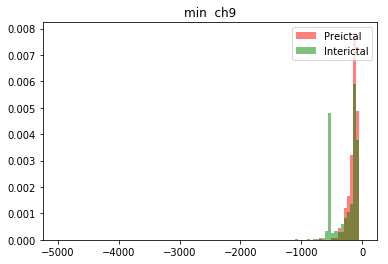

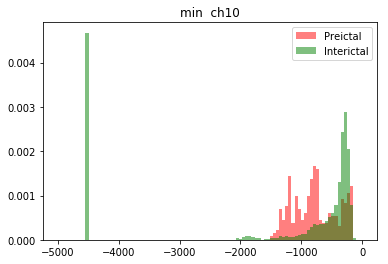

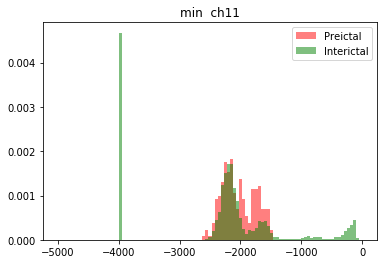

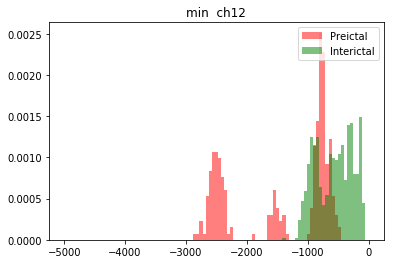

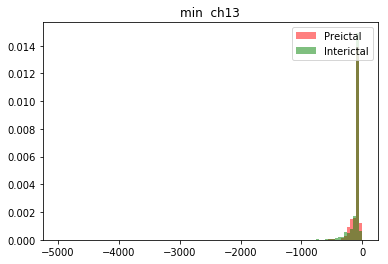

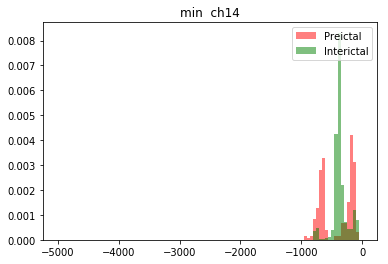

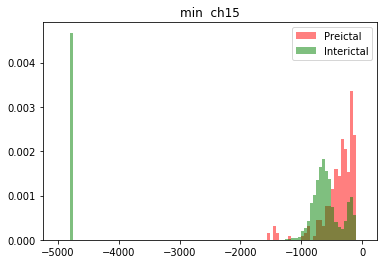

In [525]:
for ch in range(0,16):
    bins = np.linspace(-5000, 0, 100)
    feat = 'min'
    plt.figure()
    plt.hist(prefeat1[feat][ch],bins,color='red',alpha=0.5,density=True, label = 'Preictal')
    plt.hist(interfeat1[feat][ch],bins,color='green',alpha=0.5,density=True, label = 'Interictal')
    plt.legend(loc = 'upper right')
    plt.title(feat + '  ch' + str(ch))

In [486]:
os.chdir('C:\\Users\\Senan\\SpontStimAnalysis\\')
feats = features.values
np.save('sKH03respfeats.npy', feats)
np.save('sKH03resplabels.npy', labels)

In [533]:
s = np.load('sKH03respfeats.npy')
s.shape

(4417, 176)

In [527]:
os.chdir('C:\\Users\\Senan\\SpontStimAnalysis\\')
feats = features.values
np.save('sKH01respfeats.npy', feats)
np.save('sKH01resplabels.npy', labels)

In [535]:
s = np.load('sKH01resplabels.npy')
s.shape

(3622,)

In [536]:
sum(s)

260.0

In [537]:
s.shape - sum(s)

array([3362.])

In [538]:
5*49

245